In [131]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [132]:
data = pd.read_csv('train.csv')

In [133]:
for i in range(data.shape[0]):
    data['HS'].iloc[i] = data['HS'].iloc[i].replace('*','')
    data['Avg'].iloc[i] = data['Avg'].iloc[i].replace('-','0')
    

In [134]:
data

,PLAYER,Mat,Inns,NO,2018_Runs,HS,Avg,BF,SR,100,50,4s,6s,2019_Runs
0,Aaron Finch,10,9,1,134,46,16.75,100,134.00,0,0,6,8,160
1,AB de Villiers,12,11,2,480,90,53.33,275,174.54,0,6,39,30,424
2,Abhishek Sharma,3,3,2,63,46,63,33,190.90,0,0,3,5,63
3,Ajinkya Rahane,15,14,1,370,65,28.46,313,118.21,0,1,39,5,396
4,Alex Hales,6,6,0,148,45,24.66,118,125.42,0,0,13,6,165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Virat Kohli,14,14,3,530,92,48.18,381,139.10,0,4,52,18,488
96,Washington Sundar,7,6,3,65,35,21.66,38,171.05,0,0,5,4,64
97,Wriddhiman Saha,11,10,2,122,35,15.25,102,119.60,0,0,17,1,115
98,Yusuf Pathan,15,13,4,260,45,28.88,200,130.00,0,0,22,11,296


In [135]:
cols_to_norm = ['2019_Runs','2018_Runs']
data[cols_to_norm] = data[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

Text(0.5, 1.0, 'Distribution of runs')

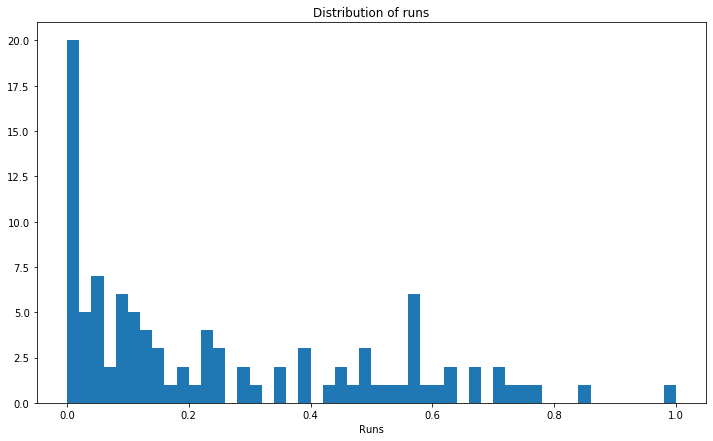

In [136]:
%matplotlib inline
plt.figure(figsize = (12,7))
plt.hist(data['2019_Runs'],bins = 50)
plt.xlabel("Runs")
plt.title("Distribution of runs")

In [137]:
x = data.drop(['2019_Runs', 'PLAYER'], axis = 1)
x = (data[['2018_Runs']])

/home/steve/venv_nsfw/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


ValueError: supplied range of [-inf, 0.0] is not finite

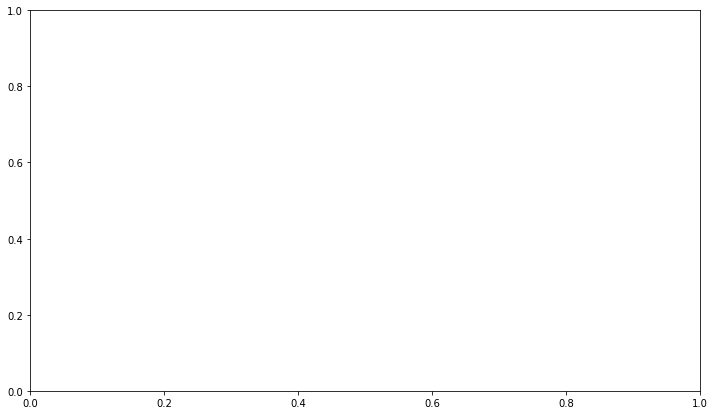

In [114]:
%matplotlib inline
plt.figure(figsize = (12,7))
plt.hist(np.log(data['2019_Runs']))
plt.xlabel("Runs")
plt.title("Distribution of runs")

In [138]:
y = (data['2019_Runs'])
# y = np.log(data['2019_Runs'])

In [139]:
x.shape, y.shape

((100, 1), (100,))

In [140]:
X = ((x.to_numpy()).astype(float))
Y = (y.to_numpy()).astype(int)

In [141]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

In [142]:
from sklearn.model_selection import train_test_split

In [143]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [144]:

x_train = torch.autograd.Variable(torch.tensor(X_train).float()) 
x_test = (torch.tensor(X_test).long())
y_train = torch.autograd.Variable(torch.tensor(Y_train).float())
y_test = torch.tensor(Y_test).long()

In [145]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [146]:
# Hyper-parameters 
input_size = X.shape[1]
hidden_size = 5
num_classes = 1
num_epochs = 10
batch_size = 10
learning_rate = 0.001

In [147]:
# Fully connected neural network with one hidden layer
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 5) 
        self.fc2 = nn.Linear(5,1)
        self.fc3 = nn.Linear(2,1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
#         out = self.fc3(out)
#         out = self.relu(out)
        return out
    
model = NeuralNet(input_size, hidden_size, num_classes).to(device)   
# Loss and optimizer
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [149]:

# Training in batches
for epoch in range(num_epochs):
    for i in tqdm(range(0, len(x_train), batch_size)): # from 0, to the len of x, stepping BATCH_SIZE at a time. [:50] ..for now just to dev
        #print(f"{i}:{i+BATCH_SIZE}")
        correct = 0
        total = 0
        batch_X = x_train[i:i+batch_size].view(-1,X.shape[1])
        batch_y = y_train[i:i+batch_size].flatten()

        model.zero_grad()

        outputs = model(batch_X)
                
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()    # Does the update

    print(f"Epoch: {epoch}. Loss: {loss} ")

100%|██████████| 8/8 [00:00<00:00, 612.98it/s]

Epoch: 0. Loss: 0.0 
Epoch: 1. Loss: 0.0 
Epoch: 2. Loss: 0.0 
Epoch: 3. Loss: 0.0 
Epoch: 4. Loss: 0.0 
Epoch: 5. Loss: 0.0 
Epoch: 6. Loss: 0.0 
Epoch: 7. Loss: 0.0 
Epoch: 8. Loss: 0.0 
Epoch: 9. Loss: 0.0 


In [150]:
for i in range(len(outputs)):    
    #print(batch_y[i],'  ', outputs[i])
    print(np.exp(batch_y[i]),'  ', np.exp(outputs[i].data))


tensor(1.)    tensor([1.])
tensor(1.)    tensor([1.])
tensor(1.)    tensor([1.])
tensor(1.)    tensor([1.])
tensor(1.)    tensor([1.])
tensor(1.)    tensor([1.])
tensor(1.)    tensor([1.])
tensor(1.)    tensor([1.])
tensor(1.)    tensor([1.])
tensor(1.)    tensor([1.])


In [ ]:
batch_X

In [77]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    correct = 0
    total = 0
    for j,k in enumerate(x_test):
        features = k.reshape(-1,12).to(device).float()
        labels = y_test[j].to(device)
        outputs = (model(features))
        for i in range(len(outputs)):
            print(np.exp(int(labels)),' ',np.exp(int(outputs)))



7.38905609893065   7.38905609893065
20.085536923187668   20.085536923187668
54.598150033144236   54.598150033144236
148.4131591025766   20.085536923187668
7.38905609893065   7.38905609893065
7.38905609893065   7.38905609893065
54.598150033144236   20.085536923187668
403.4287934927351   54.598150033144236
148.4131591025766   7.38905609893065
148.4131591025766   20.085536923187668
54.598150033144236   148.4131591025766
54.598150033144236   7.38905609893065
403.4287934927351   148.4131591025766
148.4131591025766   20.085536923187668
403.4287934927351   54.598150033144236
148.4131591025766   20.085536923187668
54.598150033144236   54.598150033144236
403.4287934927351   20.085536923187668
54.598150033144236   148.4131591025766
148.4131591025766   20.085536923187668


In [ ]:
outputs

## Actual testing 

In [78]:
data = pd.read_csv('test.csv')

In [79]:
for i in range(data.shape[0]):
    data['HS'].iloc[i] = data['HS'].iloc[i].replace('*','')
    data['Avg'].iloc[i] = data['Avg'].iloc[i].replace('-','0')

In [80]:
data.head(2)

,PLAYER,Mat,Inns,NO,2019_Runs,HS,Avg,BF,SR,100,50,4s,6s
0,David Warner,12,12,2,692,100,69.2,481,143.86,1,8,57,21
1,KL Rahul,14,14,3,593,100,53.9,438,135.38,1,6,49,25


In [81]:
players = []
for player in data['PLAYER'].values:
    player = player.replace(u'\xa0', u' ')
    players.append(str(player))
    
test = data.drop(['PLAYER'], axis = 1)
test.shape

(100, 12)

In [82]:
test = (test.to_numpy()).astype(float)
test = torch.tensor(test).float()

In [85]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    correct = 0
    total = 0
    for j,k in enumerate(test):
        features = k.reshape(-1,12).to(device).float()
        outputs = (model(features))
        for i in range(len(outputs)):
            print(players[j],' ',int(np.exp(int(outputs))))


David Warner   148
KL Rahul   54
Quinton de Kock   54
Shikhar Dhawan   54
Andre Russell   2980
Chris Gayle   54
Rishabh Pant   54
Virat Kohli   20
Shreyas Iyer   20
Jonny Bairstow   54
AB de Villiers   54
Suryakumar Yadav   20
MS Dhoni   148
Chris Lynn   20
Rohit Sharma   20
Hardik Pandya   54
Shane Watson   20
Faf du Plessis   20
Ajinkya Rahane   20
Suresh Raina   20
Parthiv Patel   20
Prithvi Shaw   20
Manish Pandey   20
Nitish Rana   20
Sanju Samson   20
Mayank Agarwal   20
Steve Smith   20
Jos Buttler   54
Shubman Gill   20
Ambati Rayudu   7
Robin Uthappa   20
Kieron Pollard   20
Dinesh Karthik   20
Vijay Shankar   20
Moeen Ali   20
David Miller   20
Marcus Stoinis   54
Colin Ingram   7
Krunal Pandya   7
Sarfaraz Khan   20
Nicholas Pooran   54
Mandeep Singh   20
Kedar Jadhav   7
Riyan Parag   20
Kane Williamson   7
Sunil Narine   403
Rahul Tripathi   7
Ben Stokes   20
Mohammad Nabi   54
Axar Patel   54
Ravindra Jadeja   54
Ishan Kishan   20
Yuvraj Singh   54
Gurkeerat Mann Singh   

In [ ]:
np.log(data['2019_Runs'])

In [ ]:
(data['2019_Runs'])

In [ ]:
np.exp(np.log(data['2019_Runs']))

In [ ]:
np.log(2.7)

In [ ]:
np.exp(0.9932517730102834)

In [97]:
temp = np.array([[2,4],[1,4]])

In [98]:
norm = np.linalg.norm(temp)


In [99]:
norm

6.082762530298219